In [91]:
import argparse
import time
import random
import uuid 
from tensorboardX import SummaryWriter

import torch as tc
import numpy as np
import torchvision

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from utils import *
from models import *
from data.data_independent import *

import matplotlib.pyplot as plt
#from data.gp_curves_gpu import GPCurvesReader
%matplotlib inline

import glob

import pandas as pd
import numpy as np
from datetime import datetime

In [128]:
# Celeba
#uuid_set = ['9d16664c'] # MVD
#uuid_set = ['0aaa2ef6'] # CNP

#uuid_set = ['dc542cdc'] # NVDP
#uuid_set = ['dc6640c0'] # NP
#uuid_set = ['c71d8600'] # NP+CNP
#uuid_set = ['dc5db748'] # NP+VP
uuid_set = ['004fb70e'] # NP+CNP+VP


# MNIST
#uuid_set = ['53d6313c'] # NVDP
#uuid_set = ['8bfb6620'] # NP+VP
#uuid_set = ['8d2727f0'] # NP+CNP+VP
#uuid_set = ['8b19d304'] # NP
#uuid_set = ['8bfb6616'] # NP+CNP



#uuid_set = ['719be6c2'] # NVDP (reduce)

#uuid_set = ['8bab937a'] # CNP


# for file_path in glob.glob('./runs/mnist/ckpt/*'):
#     uuid = file_path[-8:] 
#     if uuid in uuid_set:
#         print(uuid)
#         f_path = file_path
        
for file_path in glob.glob('./runs/celeba/ckpt/*'):
    uuid = file_path[-8:] 
    if uuid in uuid_set:
        print(uuid)
        f_path = file_path

004fb70e


In [129]:
uuid = f_path[-8:]
f_path
exp_dict = tc.load(f_path + '/ckpt.pt')
args = exp_dict['args']

In [130]:
if args.model == 'MVD_pre' or args.model == 'MVD2_pre':
    args.reduce = False
    model = LatentModelMetaVD2(args).to(args.device)
else:
    model = LatentModel(args).to(args.device)


model.load_state_dict(exp_dict['model_state'])
#writer = SummaryWriter(args.event_dir)
#with tc.no_grad():
model.eval()

LatentModel(
  (h): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1024, bias=True)
  )
  (z_encoder): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
  (d_encoder): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=128, out_features=1024, bias=True)


In [131]:
# Dataset Initialization
#dataset_train = GPCurvesReader(batch_size=16, max_num_context=96, random_kernel_parameters=True)

seeed = 17  # (20, 6, 30, 5, 108, 77, 12, 30, 17 for celeba) (10, 5, 7, 108, 1, 33, 12, 30, 17 for Omniglot, MNIST)
torch.manual_seed(seeed)
torch.cuda.manual_seed(seeed)
random.seed(seeed)

batch_size = 5 #128
#epoch = 300 #300, 100

kwargs = {'num_workers': 1, 'pin_memory': False}
transform = transforms.Compose([
transforms.CenterCrop(136),
transforms.Resize(32, interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC),
transforms.ToTensor(),
#transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

celeba_data_val = torchvision.datasets.CelebA(root="/home2/insu.jeon/.torch/datasets/celeba", split = 'valid', target_type = 'identity', transform=transform)
val_loader = torch.utils.data.DataLoader(celeba_data_val, batch_size=args.batch_size, shuffle=True, drop_last=True, **kwargs)   

#val_loader = torch.utils.data.DataLoader(dataset=OmniDataset(train=False), batch_size=args.batch_size, shuffle=True, drop_last=True,**kwargs)

#val_loader = torch.utils.data.DataLoader( datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),batch_size=args.batch_size, shuffle=True, drop_last=True, **kwargs)

In [132]:
y_t, _= next(iter(val_loader))
#img.squeeze()   
#grid_img = make_grid(img, nrow=8)
#plt.imshow(grid_img.squeeze().permute(1,2,0).cpu().detach().numpy())

In [133]:
#args.imgdim = 32
#args.x_dim = 2
#args.y_dim = 3
#args.num_point = 1024
#args.x_grid = generate_grid2(args.imgdim, args.imgdim, args.device)

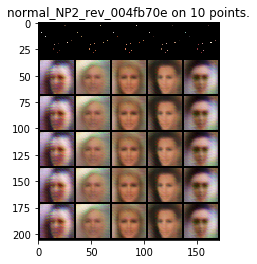

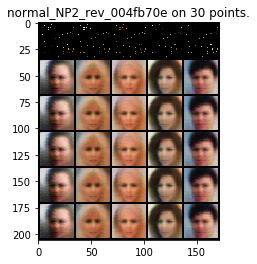

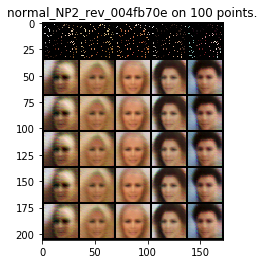

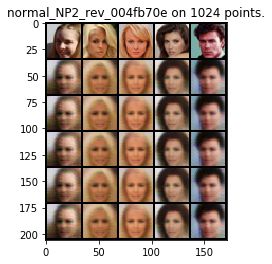

In [134]:
# addd = 10

# torch.manual_seed(seeed+addd)
# torch.cuda.manual_seed(seeed+addd)
# random.seed(seeed+addd)

plot_Ns = [10, 30, 100, args.num_point]
num_examples = min(batch_size, 16)

x_t = args.x_grid.expand(batch_size, -1, -1)
y_t = y_t[:num_examples].to(args.device).view(batch_size, -1, args.y_dim)

for N in plot_Ns:
    
    recons = []
    recons_var = []
    
    context_idx = get_context_idx(N, args.device, num_point=args.num_point)
    x_c = idx_to_x(context_idx, batch_size, args.x_grid)
    y_c = idx_to_y(context_idx, y_t[:num_examples])

    for d in range(5):
        if args.model == 'MVD_pre' or args.model == 'MVD2_pre':
            y_hat = model(x_c, y_c, x_t, sampling=True)
        else:
            y_hat, _, _ = model(x_c, y_c, x_t) #, sampling=True)

        #recons.append(torch.clamp(y_hat[0][:num_examples],0,1))
        recons.append(torch.clamp(y_hat[0][:num_examples]+0.5,0,1))
        recons_var.append(y_hat[1][:num_examples])
        
    recons = torch.cat(recons).view(-1, args.y_dim, args.imgdim, args.imgdim).expand(-1, 3, -1, -1)
    background = torch.tensor([0., 0., 0.], device=args.device)
    background = background.view(1, -1, 1).expand(num_examples, 3, args.num_point).contiguous()
    context_pixels = y_t[:num_examples].view(num_examples, args.y_dim, -1)[:, :, context_idx]
    context_pixels = context_pixels.expand(num_examples, 3, -1)
    background[:, :, context_idx] = context_pixels
    comparison = torch.cat([background.view(-1, 3, args.imgdim, args.imgdim), recons])
    #save_image(comparison.cpu(), f'results/ep_{epoch}_cps_{N}.png', nrow=num_examples)
    #save_image(comparison.cpu(), args.img_dir + f'/ep_{epoch}_cps_{N}.png', nrow=num_examples)

    fig = plt.figure()

    
    title = args.exp[:args.exp.find('(')] + '_' + uuid
    plt.title(f"{title} on {N} points.")

    grid_img = make_grid(comparison, nrow=num_examples)
    plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())
        
#     recons = torch.cat(recons_var).view(-1, args.y_dim, args.imgdim, args.imgdim).expand(-1, 3, -1, -1)
#     background = torch.tensor([0., 0., 0.], device=args.device)
#     background = background.view(1, -1, 1).expand(num_examples, 3, args.num_point).contiguous()
#     context_pixels = y_t[:num_examples].view(num_examples, args.y_dim, -1)[:, :, context_idx]
#     context_pixels = context_pixels.expand(num_examples, 3, -1)
#     background[:, :, context_idx] = context_pixels
#     comparison = torch.cat([background.view(-1, 3, args.imgdim, args.imgdim), recons])
#     #save_image(comparison.cpu(), f'results/ep_{epoch}_cps_{N}.png', nrow=num_examples)
#     #save_image(comparison.cpu(), args.img_dir + f'/ep_{epoch}_cps_{N}.png', nrow=num_examples)

#     fig = plt.figure()

    
#     title = args.exp[:args.exp.find('(')] + '_' + uuid
#     plt.title(f"{title} on {N} points.")

#     grid_img = make_grid(comparison, nrow=num_examples)
#     plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())
    fig.savefig(f'./images_celeba/{title} on {N} points9.png', transparent=True,  dpi=200,  interpolation='none')
    #fig.savefig(f'./images_mnist/{title} on {N} points9.png', transparent=True,  dpi=200,  interpolation='none')
#     grid_img = make_grid(comparison, nrow=num_examples, normalize=True, range=(-1,1))
#     writer.add_image(f'cps_{N}', grid_img, epoch)


In [135]:
args.model

'NP2_rev'

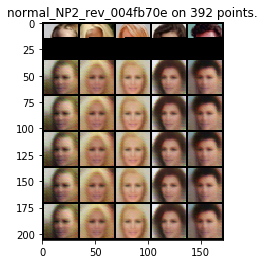

In [136]:


x_t = args.x_grid.expand(batch_size, -1, -1)
y_t = y_t[:num_examples].to(args.device).view(batch_size, -1, args.y_dim)

   
recons = []
recons_var = []
N = 392
context_idx = torch.arange(0,N).cuda()
num_examples = min(batch_size, 16)
x_c = idx_to_x(context_idx, batch_size, args.x_grid)
y_c = idx_to_y(context_idx, y_t[:num_examples])


for d in range(5):
    if args.model == 'MVD_pre' or args.model == 'MVD2_pre':
        y_hat = model(x_c, y_c, x_t, sampling=True)
    else:
        y_hat, _, _ = model(x_c, y_c, x_t) #, sampling=True)

    #recons.append(torch.clamp(y_hat[0][:num_examples],0,1))
    recons.append(torch.clamp(y_hat[0][:num_examples]+0.5,0,1))
    recons_var.append(y_hat[1][:num_examples])

recons = torch.cat(recons).view(-1, args.y_dim, args.imgdim, args.imgdim).expand(-1, 3, -1, -1)
background = torch.tensor([0., 0., 0.], device=args.device)
background = background.view(1, -1, 1).expand(num_examples, 3, args.num_point).contiguous()
context_pixels = y_t[:num_examples].view(num_examples, args.y_dim, -1)[:, :, context_idx]
context_pixels = context_pixels.expand(num_examples, 3, -1)
background[:, :, context_idx] = context_pixels
comparison = torch.cat([background.view(-1, 3, args.imgdim, args.imgdim), recons])
#save_image(comparison.cpu(), f'results/ep_{epoch}_cps_{N}.png', nrow=num_examples)
#save_image(comparison.cpu(), args.img_dir + f'/ep_{epoch}_cps_{N}.png', nrow=num_examples)

fig = plt.figure()


title = args.exp[:args.exp.find('(')] + '_' + uuid
plt.title(f"{title} on {N} points.")

grid_img = make_grid(comparison, nrow=num_examples)
plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())
        
#     recons = torch.cat(recons_var).view(-1, args.y_dim, args.imgdim, args.imgdim).expand(-1, 3, -1, -1)
#     background = torch.tensor([0., 0., 0.], device=args.device)
#     background = background.view(1, -1, 1).expand(num_examples, 3, args.num_point).contiguous()
#     context_pixels = y_t[:num_examples].view(num_examples, args.y_dim, -1)[:, :, context_idx]
#     context_pixels = context_pixels.expand(num_examples, 3, -1)
#     background[:, :, context_idx] = context_pixels
#     comparison = torch.cat([background.view(-1, 3, args.imgdim, args.imgdim), recons])
#     #save_image(comparison.cpu(), f'results/ep_{epoch}_cps_{N}.png', nrow=num_examples)
#     #save_image(comparison.cpu(), args.img_dir + f'/ep_{epoch}_cps_{N}.png', nrow=num_examples)

#     fig = plt.figure()

    
#     title = args.exp[:args.exp.find('(')] + '_' + uuid
#     plt.title(f"{title} on {N} points.")

#     grid_img = make_grid(comparison, nrow=num_examples)
#     plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())

fig.savefig(f'./images_celeba/{title} on {N} points9.png', transparent=True,  dpi=200,  interpolation='none')
#fig.savefig(f'./images_mnist/{title} on {N} points9.png', transparent=True,  dpi=200,  interpolation='none')
#     grid_img = make_grid(comparison, nrow=num_examples, normalize=True, range=(-1,1))
#     writer.add_image(f'cps_{N}', grid_img, epoch)


500

In [13]:
writer = SummaryWriter(args.event_dir)

def test(epoch):
    model.eval()
    #global g_iter

    LL = []
    Recon_LL = []
    Pred_LL = []

    batch_size = args.batch_size

    with torch.no_grad():
        for batch_idx, (y_t,_) in enumerate(val_loader):

            x_t = args.x_grid.expand(args.batch_size, -1, -1)
            y_t = y_t.to(args.device).view(args.batch_size, -1, args.y_dim)

#             if batch_idx == 0:  # save PNG of reconstructed examples
#                 plot_Ns = [10, 30, 100, args.num_point]
#                 num_examples = min(batch_size, 16)
#                 for N in plot_Ns:
#                     recons = []
#                     context_idx = get_context_idx(N, args.device, num_point=args.num_point)
#                     x_c = idx_to_x(context_idx, batch_size, args.x_grid)
#                     y_c = idx_to_y(context_idx, y_t)

#                     for d in range(5):
#                         y_hat = model(x_c, y_c, x_t)
#                         #recons.append(inv_normalize(y_hat[0][:num_examples]).clamp(min=0.0,max=1.0))
#                         recons.append( torch.clamp(y_hat[0][:num_examples]+0.5,0,1) )

#                     recons = torch.cat(recons).view(-1, args.y_dim, args.imgdim, args.imgdim).expand(-1, 3, -1, -1)
#                     background = torch.tensor([0., 0., 0.], device=args.device)
#                     background = background.view(1, -1, 1).expand(num_examples, 3, args.num_point).contiguous()
#                     context_pixels = y_t[:num_examples].view(num_examples, args.y_dim, -1)[:, :, context_idx]
#                     context_pixels = context_pixels.expand(num_examples, 3, -1)
#                     background[:, :, context_idx] = context_pixels
#                     comparison = torch.cat([background.view(-1, 3, args.imgdim, args.imgdim), recons])
#                     #save_image(comparison.cpu(), f'results/ep_{epoch}_cps_{N}.png', nrow=num_examples)
#                     #save_image(comparison.cpu(), args.img_dir + f'/ep_{epoch}_cps_{N}.png', nrow=num_examples)

#                     fig = plt.figure()
#                     plt.title(f"Conditioned on {N} context points (epoch {epoch}).")
#                     grid_img = make_grid(comparison, nrow=num_examples)
#                     writer.add_image(f'cps_{N}', grid_img, epoch)

            ################## ANP setting ##################
            num_context = random.randint(3, 196)  # number of context points ([3,197))
            num_target = args.num_point # number of target points 784
            rand_idx = get_context_idx(num_target, args.device, num_point=args.num_point)
            x_c = idx_to_x(rand_idx[:num_context], args.batch_size, args.x_grid)
            y_c = idx_to_y(rand_idx[:num_context], y_t)
            x_t = idx_to_x(rand_idx, args.batch_size, args.x_grid)
            y_t = idx_to_y(rand_idx, y_t)
            ################################################

#             y_pred = model(x_c, y_c, x_t, y_t)
            if args.model == 'MVD_pre' or args.model == 'MVD2_pre':
                y_pred = model(x_c, y_c, x_t)
            else:
                y_pred, _, _ = model(x_c, y_c, x_t) #, sampling=True)
        
            y_dist = Normal(y_pred[0], y_pred[1])
            log_p = y_dist.log_prob(y_t-0.5)

            #LL += log_p.mean().item() # LL for all given context
            LL.append(log_p.mean().item())
            #Recon_LL += log_p[:, :num_context, :].mean().item()
            Recon_LL.append(log_p[:, :num_context, :].mean().item())
            #Pred_LL += log_p[:, num_context:, :].mean().item()
            Pred_LL.append(log_p[:, num_context:, :].mean().item())

    writer.add_scalar(f'val_omni/LL', torch.Tensor(LL).mean().item(), epoch)
    writer.add_scalar(f'val_omni/Recon_LL', torch.Tensor(Recon_LL).mean().item(), epoch)
    writer.add_scalar(f'val_omni/Pred_LL', torch.Tensor(Pred_LL).mean().item(), epoch)
    writer.add_scalar(f'val_omni/LL(STD)', torch.Tensor(LL).std().item(), epoch)
    writer.add_scalar(f'val_omni/Recon_LL(STD)', torch.Tensor(Recon_LL).std().item(), epoch)
    writer.add_scalar(f'val_omni/Pred_LL(STD)', torch.Tensor(Pred_LL).std().item(), epoch)

    print(f'====> Val LL: {torch.Tensor(LL).mean().item():.4f}')
    print(f'====> Val Recon_LL: {torch.Tensor(Recon_LL).mean().item():.4f}')
    print(f'====> Val Pred_LL: {torch.Tensor(Pred_LL).mean().item():.4f}')
    print(f'====> Val LL(STD): {torch.Tensor(LL).std().item():.4f}')
    print(f'====> Val Recon_LL(STD): {torch.Tensor(Recon_LL).std().item():.4f}')
    print(f'====> Val Pred_LL(STD): {torch.Tensor(Pred_LL).std().item():.4f}')


In [14]:
test(args.epochs)

====> Val LL: 0.6892
====> Val Recon_LL: 1.0245
====> Val Pred_LL: 0.6479
====> Val LL(STD): 0.1327
====> Val Recon_LL(STD): 0.0810
====> Val Pred_LL(STD): 0.1279
